In [1]:
from __future__ import print_function
from __future__ import absolute_import

import os
from PIL import Image
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf

from imm.models.imm_model import IMMModel
from imm.eval.eval_imm import load_configs
from imm.utils.plot_landmarks import plot_landmarks

In [2]:
# configuration
image_size = [128, 128] # h, w
paths_config = os.path.join('..', 'configs', 'paths', 'default.yaml')
experiment_name = 'aflw-10pts-finetune'
images_dir =  os.path.join('resources', 'visualize')

config = load_configs(
    [paths_config,
     os.path.join('..', 'configs', 'experiments', experiment_name + '.yaml')])

checkpoint_name = 'model.ckpt'
checkpoint_file = os.path.join(config.training.logdir, checkpoint_name)

In [3]:
# load images
image_files = os.listdir(images_dir)
images = []
for image_file in image_files:
    image = Image.open(os.path.join(images_dir, image_file))
    image = np.array(image.resize(image_size[::-1]), dtype=np.float32)
    images.append(image)
images = np.array(images)

In [4]:
with tf.Graph().as_default() as graph:
    # set up dataset
    dataset = tf.data.Dataset.from_tensors({'image': images, 'future_image': images})
    iterator = dataset.make_one_shot_iterator()
    inputs = iterator.get_next()
    
    # set up model
    training_pl = False
    net_instance = IMMModel(config.model)
    _, _, _, tensors = net_instance.build(
        inputs, training_pl=training_pl, output_tensors=True, build_loss=False)
    
    # start a new session
    session_config = tf.ConfigProto(allow_soft_placement=True,
                                    log_device_placement=False)
    session_config.gpu_options.allow_growth = True
    with tf.Session(config=session_config) as session:
        global_init = tf.global_variables_initializer()
        local_init = tf.local_variables_initializer()
        session.run([global_init, local_init])

        # restore checkpoint
        if tf.gfile.Exists(checkpoint_file) or tf.gfile.Exists(checkpoint_file + '.index'):
            reader = tf.train.NewCheckpointReader(checkpoint_file)
            vars_to_restore = tf.global_variables()
            checkpoint_vars = reader.get_variable_to_shape_map().keys()
            vars_ignored = [
                v.name for v in vars_to_restore if v.name[:-2] not in checkpoint_vars]
            if vars_ignored:
                print('vars-IGNORED (not restoring)')
                print(', '.join(vars_ignored))
            vars_to_restore = [
                v for v in vars_to_restore if v.name[:-2] in checkpoint_vars]
            restorer = tf.train.Saver(var_list=vars_to_restore)
            restorer.restore(session, checkpoint_file)
        else:
            raise Exception('model file does not exist at: ' + checkpoint_file)

        # evaluate model
        landmarks = session.run(tensors['gauss_yx'])    

INFO:tensorflow:Restoring parameters from /scratch/local/hdd/ankush/minmaxinfo/data/release/logs/aflw-10pts-finetune/model.ckpt


In [5]:
# denormalize landmarks
landmarks = ((landmarks + 1) / 2.0) * np.array(image_size)

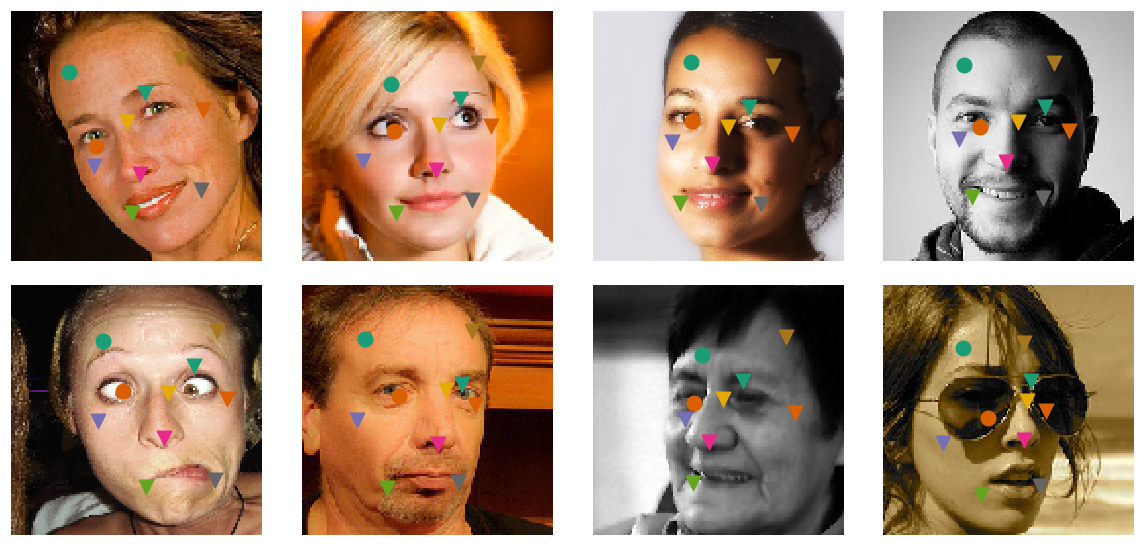

In [6]:
# plot unsupervised landmarks
cols = min(4, len(images))
rows = int(np.ceil(len(images) / float(cols)))
fig, axs = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
for i, ax in enumerate(np.ravel(axs)):
    if i < len(images):
        ax.imshow(images[i].astype(np.uint8))
        plot_landmarks(ax, landmarks[i], size=2.5)
    plt.tight_layout()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_axis_off()